# Sign Language Recognition using MediaPipe and LSTM

This notebook demonstrates the process of building a gesture recognition system using MediaPipe and a Long Short-Term Memory (LSTM) network. The system is designed to recognize a set of predefined gestures performed by a user.

**Workflow:**

1. **Data Acquisition:** We use MediaPipe's Holistic model to extract hand and pose landmarks from videos of different gestures.
2. **Data Preprocessing:** The extracted landmarks are preprocessed and organized into a format suitable for training the LSTM model.
3. **Model Training:** An LSTM network is trained on the preprocessed data to learn the patterns associated with each gesture.
4. **Model Evaluation:** The trained model is evaluated on a separate test set to assess its performance and identify potential areas for improvement.
5. **Model Testing:** The model is tested with a single video to showcase its gesture recognition capabilities.

**Libraries Used:**

* MediaPipe: For hand and pose estimation.
* OpenCV: For image and video processing.
* NumPy: For numerical computations.
* TensorFlow/Keras: For building and training the LSTM model.

**Objectives:**

* To build a sign language recognition system using MediaPipe and LSTM.
* To demonstrate the process of data acquisition, preprocessing, model training, and evaluation.

# Specifying Libraries and Functions

**IMPORTANT:**
Before running this notebook, please make sure to mount your Google Drive to access the necessary files. You can do this by clicking on the "Mount Drive" button in the file explorer on the left.

In [54]:
!pip install mediapipe

In [55]:
!pip install opencv-python

In [56]:
# Install required libraries
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from google.colab.patches import cv2_imshow

mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Color conversion from BGR to RGB
    image.flags.writeable = False                   # Image is no longer writeable
    results = model.process(image)                  # Make prediction
    image.flags.writeable = True                    # Image is no longer writeable
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)   # Color conversion RGB to BGR
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)  # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)    # Draw right connections

def draw_styled_landmarks(image,results):

    # Draw pose connection
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0,0,255), thickness=1,circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1,circle_radius=1)
                              )
    # Draw left hand connection
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0,0,255), thickness=1,circle_radius=2),
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1,circle_radius=1)
                              )
    # Draw right hand connection
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0,0,255), thickness=1,circle_radius=2),
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1,circle_radius=1)
                              )

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

    return np.concatenate([pose, lh, rh])



Mounted at /content/drive
Drive remounted with write access


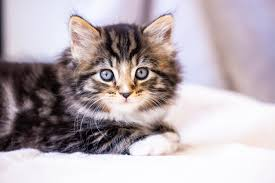

In [57]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # Remount with force_remount=True
print('Drive remounted with write access')

def detect_hand_landmarks(image_path):
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Make detections
        image, results = mediapipe_detection(image, holistic)

        # Draw landmarks to the frame
        draw_styled_landmarks(image,results)

        # Convert the image back to BGR for OpenCV
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Display the image with hand landmarks
        cv2_imshow(image)


# Testing mediapipe
# Path to your own image file
image_path = '/content/drive/MyDrive/images.jpeg'

# Call the function to detect hand landmarks
detect_hand_landmarks(image_path)


In [58]:
# Specify the path you upload the videos in the Google Drive
video_directory = r'/content/drive/MyDrive/Occ2_Group7'

# Get all file names in the directory
gestures_files = os.listdir(video_directory)

# Specify the gestures
gestures = np.array(gestures_files)

glosses = ['waalaikumussalam', 'selamat_pagi', 'anak', 'duit', 'awak']

# only keep the glosses assigned to me
gestures = np.array([g for g in gestures if g in glosses])

print(gestures)

['selamat_pagi' 'duit' 'waalaikumussalam' 'anak' 'awak']


# Data Acquisition
In this part, it process a every gesture videos in the dataset folder to extract and save keypoint data for hand, body, and face landmarks using MediaPipe's Holistic model. For each gesture category, it iterates through associated video files, detects landmarks in up to 30 frames per video, and stores the extracted keypoints in .npy files.

In [59]:
# Specify your path to store landmarks files
train_dataset_path = '/content/drive/MyDrive/Occ2_Group7_landmarks'

for ges in gestures:

    # Specify the video path
    data_path = os.path.join(video_directory, ges)
    data_video = os.listdir(data_path)

    for vid in data_video:

        if not os.path.exists(os.path.join(train_dataset_path)):
            os.makedirs(train_dataset_path)

        # Changed: Create directory for landmarks without filename
        landmark_path = os.path.join(train_dataset_path, ges, vid.split('.')[0])
        video_path = os.path.join(video_directory, ges, vid)
        print(video_path)


        # Locate the video dataset
        video = cv2.VideoCapture(video_path)

        count = 0
        frame_count = 0

        # Set mediapipe model
        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            while True:
                ret, frame = video.read()

                if not ret or frame_count == 30:
                    # Break the loop if there are no more frames
                    break

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks to the frame
                draw_styled_landmarks(image,results)

                # Check if hands are present
                # This part ensures that only frames with detected hand landmarks are saved.
                if results.left_hand_landmarks or results.right_hand_landmarks:

                    # Create landmark files
                    if not os.path.exists(landmark_path):
                        os.makedirs(landmark_path)

                    # Extract keypoint
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(landmark_path, str(count + 1))
                    np.save(npy_path, keypoints)
                    print(f"Extract: {npy_path}")

                    frame_count += 1

                count += 1



/content/drive/MyDrive/Occ2_Group7/selamat_pagi/selamat_pagi_Occ2_Group7_3.mp4
Extract: /content/drive/MyDrive/Occ2_Group7_landmarks/selamat_pagi/selamat_pagi_Occ2_Group7_3/37
Extract: /content/drive/MyDrive/Occ2_Group7_landmarks/selamat_pagi/selamat_pagi_Occ2_Group7_3/39
Extract: /content/drive/MyDrive/Occ2_Group7_landmarks/selamat_pagi/selamat_pagi_Occ2_Group7_3/40
Extract: /content/drive/MyDrive/Occ2_Group7_landmarks/selamat_pagi/selamat_pagi_Occ2_Group7_3/41
Extract: /content/drive/MyDrive/Occ2_Group7_landmarks/selamat_pagi/selamat_pagi_Occ2_Group7_3/43
Extract: /content/drive/MyDrive/Occ2_Group7_landmarks/selamat_pagi/selamat_pagi_Occ2_Group7_3/45
Extract: /content/drive/MyDrive/Occ2_Group7_landmarks/selamat_pagi/selamat_pagi_Occ2_Group7_3/46
Extract: /content/drive/MyDrive/Occ2_Group7_landmarks/selamat_pagi/selamat_pagi_Occ2_Group7_3/47
Extract: /content/drive/MyDrive/Occ2_Group7_landmarks/selamat_pagi/selamat_pagi_Occ2_Group7_3/48
Extract: /content/drive/MyDrive/Occ2_Group7_land

# Data Preprocess and Label

This part processes  landmark files (.npy files) for different gestures stored in the directory. Each gesture is represented as a sequence of landmarks (e.g., coordinates of hands, face, and pose). The goal is to extract these sequences from stored files, organize them into a dataset (gestures_sequence), and pair them with corresponding numeric labels (labels). These labels are generated using a mapping from gesture names to integers (label_map).

### Expected Output
1. [Structure of gestures_sequence] A NumPy array with shape (N, F, L), where:
- N = number of gesture instances (e.g., number of processed videos or data samples).
- F = number of frames per gesture instance (variable depending on the video length).
- L = number of landmarks per frame (for this case 126 landmarks, which are total landmarks of hands, face and pose).

2. [Structure of labels] A NumPy array with shape (N,) containing numeric labels corresponding to the gestures.

In [60]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [61]:
label_map = {label: num for num, label in enumerate(gestures)}
len(label_map)

5

In [62]:

gesture_sequence, labels = [], []

for gs in gestures:
    gesture = []

    for fname in os.listdir(os.path.join(train_dataset_path, gs)):
        path = os.path.join(train_dataset_path, gs, fname)
        if os.path.isdir(path):
            gesture.append(fname)

    for no in gesture:
        load_path = os.path.join(train_dataset_path, gs, no)
        npy_files = sorted([f for f in os.listdir(load_path) if f.endswith('.npy')])
        npy_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

        video = []
        for npy in npy_files:
            video.append(np.load(os.path.join(load_path, npy)))
            print(os.path.join(load_path, npy))

        gesture_sequence.append(video)
        labels.append(label_map[gs])

    # Calculate the maximum sequence length for this gesture
    max_len = max(len(seq) for seq in gesture_sequence)

    # Pad shorter sequences with zeros to match the maximum length
    gesture_sequence = [
        seq + [[0] * seq[0].shape[0]] * (max_len - len(seq))  # Pad with zeros
        for seq in gesture_sequence
    ]

    print(np.array(gesture_sequence).shape, np.array(labels).shape)

X = np.array(gesture_sequence)
y = np.array(labels)

np.save('X_TRAIN_2.npy', X)
np.save('y_TRAIN_2.npy', y)

/content/drive/MyDrive/Occ2_Group7_landmarks/selamat_pagi/selamat_pagi_Occ2_Group7_3/37.npy
/content/drive/MyDrive/Occ2_Group7_landmarks/selamat_pagi/selamat_pagi_Occ2_Group7_3/39.npy
/content/drive/MyDrive/Occ2_Group7_landmarks/selamat_pagi/selamat_pagi_Occ2_Group7_3/40.npy
/content/drive/MyDrive/Occ2_Group7_landmarks/selamat_pagi/selamat_pagi_Occ2_Group7_3/41.npy
/content/drive/MyDrive/Occ2_Group7_landmarks/selamat_pagi/selamat_pagi_Occ2_Group7_3/43.npy
/content/drive/MyDrive/Occ2_Group7_landmarks/selamat_pagi/selamat_pagi_Occ2_Group7_3/45.npy
/content/drive/MyDrive/Occ2_Group7_landmarks/selamat_pagi/selamat_pagi_Occ2_Group7_3/46.npy
/content/drive/MyDrive/Occ2_Group7_landmarks/selamat_pagi/selamat_pagi_Occ2_Group7_3/47.npy
/content/drive/MyDrive/Occ2_Group7_landmarks/selamat_pagi/selamat_pagi_Occ2_Group7_3/48.npy
/content/drive/MyDrive/Occ2_Group7_landmarks/selamat_pagi/selamat_pagi_Occ2_Group7_3/49.npy
/content/drive/MyDrive/Occ2_Group7_landmarks/selamat_pagi/selamat_pagi_Occ2_Grou

In [63]:
X = np.load('X_TRAIN_2.npy')
y = np.load('y_TRAIN_2.npy')

print(X.shape, y.shape)

(30, 30, 258) (30,)


In [64]:
# Convert the labels into a one-hot encoded format for classification
# For example, if there are 3 classes, label 1 becomes [0, 1, 0], label 2 becomes [0, 0, 1], etc.
y = to_categorical(labels).astype(int)

# Split the dataset into training and testing sets
# - `test_size=0.05`: 5% of the data will be used for testing
# - The remaining 95% will be used for training
# - `X_train` and `y_train`: Input features and labels for training
# - `X_test` and `y_test`: Input features and labels for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Training Model

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

With Hyperparameters:
- Batch Size = 32
- Learning Rate = Default (0.001)
- Hidden Layer Size = 64

In [76]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert your dataset to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.argmax(axis=1), dtype=torch.long)  # Convert to class indices
y_test_tensor = torch.tensor(y_test.argmax(axis=1), dtype=torch.long)

# Create DataLoader to manage batches
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define your custom LSTM model and move to the GPU
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, num_classes)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = torch.relu(self.fc1(x[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.output_layer(x)
        return x

# Create model and move to GPU
input_size = 258
hidden_size = 64
num_classes = len(gestures)
model = CustomLSTM(input_size, hidden_size, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters()) # Default value for LR = 0.001
# optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Adjust learning rate


# Train the model on the GPU
num_epochs = 200
loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    # Iterate through batches
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()  # Reset gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        epoch_loss += loss.item()  # Accumulate loss

    # Print epoch stats
    if (epoch + 1) % 10 == 0:
        loss_history.append(epoch_loss / len(train_loader))
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

# Evaluate the model
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()
        predicted = outputs.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {accuracy:.4f}')


Using device: cuda
Epoch [10/200], Loss: 1.5944
Epoch [20/200], Loss: 1.5565
Epoch [30/200], Loss: 1.3961
Epoch [40/200], Loss: 1.2647
Epoch [50/200], Loss: 0.9929
Epoch [60/200], Loss: 0.8419
Epoch [70/200], Loss: 0.7780
Epoch [80/200], Loss: 0.7653
Epoch [90/200], Loss: 0.7242
Epoch [100/200], Loss: 0.5897
Epoch [110/200], Loss: 0.8823
Epoch [120/200], Loss: 0.6790
Epoch [130/200], Loss: 0.5146
Epoch [140/200], Loss: 0.4565
Epoch [150/200], Loss: 1.9970
Epoch [160/200], Loss: 0.9682
Epoch [170/200], Loss: 0.8503
Epoch [180/200], Loss: 0.6967
Epoch [190/200], Loss: 0.7486
Epoch [200/200], Loss: 0.5171
Test Loss: 0.4582, Test Accuracy: 0.6667


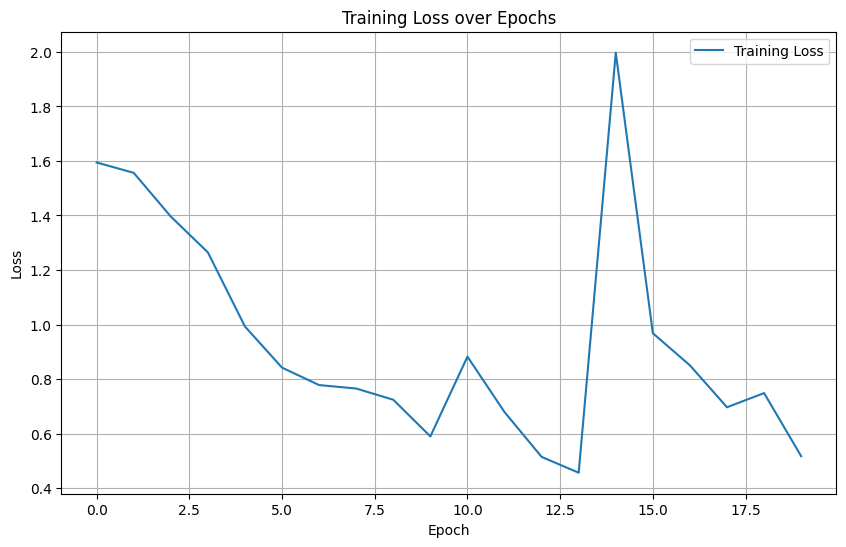

In [77]:
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
# Save the trained model
model_filename = 'trained_model.pth'
torch.save(model.state_dict(), model_filename)
print(f"Model saved as {model_filename}")

Model saved as trained_model.pth


# Model Evaluation

Evaluates the performance of the trained model. The goal is to assess how well the model generalizes to unseen data and identify potential areas for improvement.

**Evaluation Metrics:**

1. **Accuracy:** Measures the overall correctness of the model's predictions.
2. **Confusion Matrix:** Provides a detailed breakdown of the model's predictions, showing the number of true positives, true negatives, false positives, and false negatives for each gesture class.
3. **Classification Report:** Offers a comprehensive overview of the model's performance, including precision, recall, F1-score, and support for each gesture class.

**Visualization:**

* Confusion Matrix Heatmap: A visual representation of the confusion matrix using a heatmap, aiding in understanding the model's performance across different classes.
* Classification Report Heatmap: A heatmap visualizing the classification report, providing a quick overview of key metrics for each class.


In [79]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd  # Add this line

Evaluating the model while Hyperparameters during training were:
- Batch Size = 32
- Learning Rate = Default (0.001)
- Hidden Layer Size = 64

Test Loss: 0.4582, Test Accuracy: 0.6667
Confusion Matrix:
[[1 0 0 0 0]
 [0 2 0 0 0]
 [0 0 0 0 0]
 [1 0 0 1 0]
 [0 0 1 0 0]]


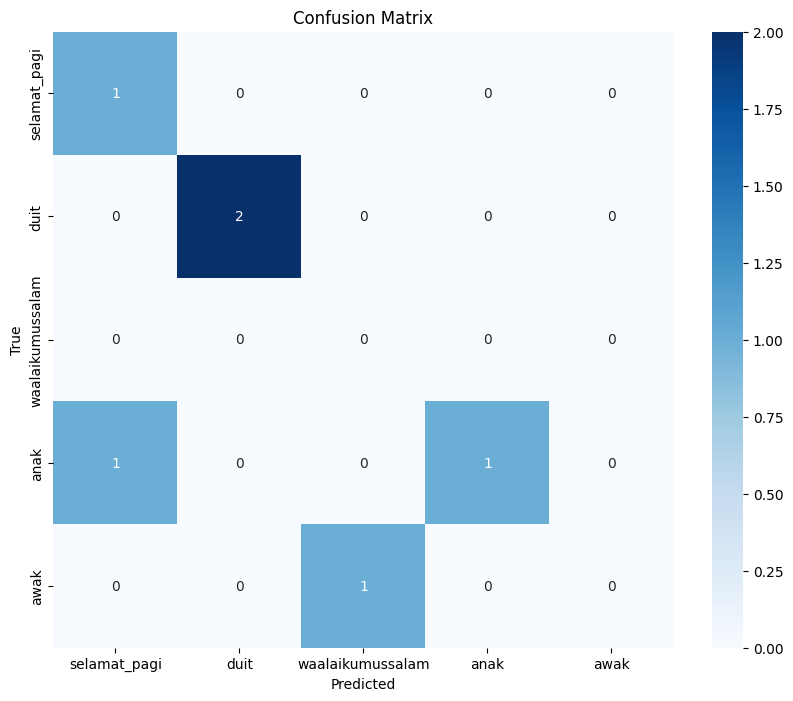

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Classification Report:
                  precision    recall  f1-score   support

    selamat_pagi       0.50      1.00      0.67         1
            duit       1.00      1.00      1.00         2
waalaikumussalam       0.00      0.00      0.00         0
            anak       1.00      0.50      0.67         2
            awak       0.00      0.00      0.00         1

        accuracy                           0.67         6
       macro avg       0.50      0.50      0.47         6
    weighted avg       0.75      0.67      0.67         6



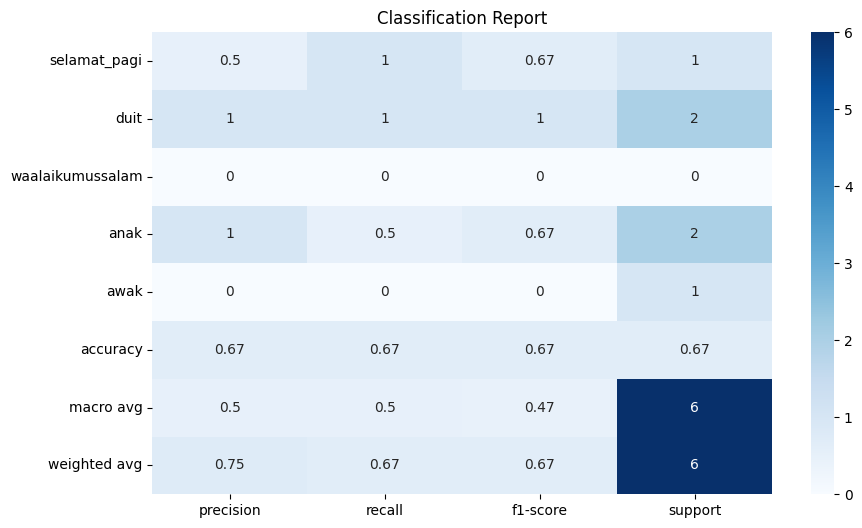

In [80]:
# Evaluate the model on the GPU
model.eval()
with torch.no_grad():
    # Convert X_test to a PyTorch tensor and move to GPU
    test_outputs = model(torch.tensor(X_test, dtype=torch.float32).to(device))

    # Convert y_test to a PyTorch tensor of class indices and move to GPU
    y_test_tensor = torch.tensor(y_test.argmax(axis=1), dtype=torch.long).to(device)

    # Compute the test loss
    test_loss = criterion(test_outputs, y_test_tensor)

    # Calculate accuracy
    accuracy = (test_outputs.argmax(dim=1) == y_test_tensor).float().mean()
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy.item():.4f}')

    # Convert predictions and true labels to numpy arrays
    predicted_labels = test_outputs.argmax(dim=1).cpu().numpy()
    true_labels = y_test_tensor.cpu().numpy()

    # Calculate and print the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=gestures, yticklabels=gestures)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Calculate and print the classification report
    # class_report = classification_report(true_labels, predicted_labels, target_names=gestures)
    # print("Classification Report:")
    # print(class_report)
    unique_labels = np.unique(np.concatenate((true_labels, predicted_labels)))

    # Filter target names to match unique labels
    filtered_target_names = [gestures[i] for i in unique_labels]

    class_report = classification_report(
        true_labels,
        predicted_labels,
        target_names=filtered_target_names,
        labels=unique_labels  # Add labels parameter
    )
    print("Classification Report:")
    print(class_report)

    # Plot the classification report
    # plt.figure(figsize=(10, 6))
    # sns.heatmap(pd.DataFrame.from_dict(classification_report(true_labels, predicted_labels, target_names=gestures, output_dict=True)).T, annot=True, cmap='Blues')
    # plt.title('Classification Report')
    # plt.show()

    # Plot the classification report
    plt.figure(figsize=(10, 6))
    # Use filtered_target_names instead of gestures
    sns.heatmap(pd.DataFrame.from_dict(classification_report(true_labels, predicted_labels, target_names=filtered_target_names, output_dict=True)).T, annot=True, cmap='Blues')
    plt.title('Classification Report')
    plt.show()


# Model Testing

Testing the model with a single video while Hyperparameters during training were:
- Batch Size = 32
- Learning Rate = Default (0.001)
- Hidden Layer Size = 64

In [81]:
# Define your custom LSTM model
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, num_classes)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = torch.relu(self.fc1(x[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.output_layer(x)
        return x

# Instantiate the model
input_size = 258
# input_size = 1662
hidden_size = 64
num_classes = len(gestures)
model = CustomLSTM(input_size, hidden_size, num_classes)

# Load the saved model state dictionary
model_filename = 'trained_model.pth'
loaded_model_state_dict = torch.load(model_filename)

# Load the state dictionary into the model
model.load_state_dict(loaded_model_state_dict)
model.eval()  # Set the model to evaluation mode



colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    return output_frame


def get_shape(data):
    if not isinstance(data, list):
        return ()
    return (len(data),) + get_shape(data[0])


# 1. New detection variables
sequence = []
sentence = []
predictions = []

# Replace 'video.mp4' with the path to your video file
cap = cv2.VideoCapture('/content/drive/MyDrive/Occ2_Group7/awak/awak_Occ2_Group7_6.mp4')

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Exit loop if video ends
        if not ret:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if results.left_hand_landmarks or results.right_hand_landmarks:
            if len(sequence) == 30:
                res = model(torch.tensor(np.expand_dims(sequence, axis=0), dtype=torch.float32))
                max_val, max_idx = torch.max(res, dim=1)

                # Print prediction result
                print(max_val)
                print(max_idx)
                print(gestures[max_idx])




<ipython-input-81-1a8e636cd377>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_state_dict = torch.load(model_filename)


tensor([1.4780], grad_fn=<MaxBackward0>)
tensor([2])
waalaikumussalam
tensor([1.4371], grad_fn=<MaxBackward0>)
tensor([2])
waalaikumussalam
tensor([1.3944], grad_fn=<MaxBackward0>)
tensor([2])
waalaikumussalam
tensor([1.3531], grad_fn=<MaxBackward0>)
tensor([2])
waalaikumussalam
tensor([1.3070], grad_fn=<MaxBackward0>)
tensor([2])
waalaikumussalam
tensor([1.2605], grad_fn=<MaxBackward0>)
tensor([2])
waalaikumussalam
tensor([1.2166], grad_fn=<MaxBackward0>)
tensor([2])
waalaikumussalam
tensor([1.1706], grad_fn=<MaxBackward0>)
tensor([2])
waalaikumussalam
tensor([1.1133], grad_fn=<MaxBackward0>)
tensor([2])
waalaikumussalam
tensor([1.0270], grad_fn=<MaxBackward0>)
tensor([2])
waalaikumussalam
tensor([0.8227], grad_fn=<MaxBackward0>)
tensor([2])
waalaikumussalam
tensor([0.6020], grad_fn=<MaxBackward0>)
tensor([4])
awak
tensor([0.6227], grad_fn=<MaxBackward0>)
tensor([4])
awak
tensor([1.1834], grad_fn=<MaxBackward0>)
tensor([4])
awak
tensor([2.0096], grad_fn=<MaxBackward0>)
tensor([4])
awa

# Training Model

With Hyperparameters:
- Batch Size = 64
- Learning Rate = 0.0005
- Hidden Layer Size = 128

In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert your dataset to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.argmax(axis=1), dtype=torch.long)  # Convert to class indices
y_test_tensor = torch.tensor(y_test.argmax(axis=1), dtype=torch.long)

# Create DataLoader to manage batches
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define your custom LSTM model and move to the GPU
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, num_classes)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = torch.relu(self.fc1(x[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.output_layer(x)
        return x

# Create model and move to GPU
input_size = 258
hidden_size = 128
num_classes = len(gestures)
model = CustomLSTM(input_size, hidden_size, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Adjust learning rate


# Train the model on the GPU
num_epochs = 200
loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    # Iterate through batches
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()  # Reset gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        epoch_loss += loss.item()  # Accumulate loss

    # Print epoch stats
    if (epoch + 1) % 10 == 0:
        loss_history.append(epoch_loss / len(train_loader))
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

# Evaluate the model
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()
        predicted = outputs.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {accuracy:.4f}')


# Save the trained model
model_filename = 'trained_model.pth'
torch.save(model.state_dict(), model_filename)
print(f"Model saved as {model_filename}")


Using device: cuda
Epoch [10/200], Loss: 1.6101
Epoch [20/200], Loss: 1.5952
Epoch [30/200], Loss: 1.5195
Epoch [40/200], Loss: 1.4007
Epoch [50/200], Loss: 1.2386
Epoch [60/200], Loss: 1.1547
Epoch [70/200], Loss: 1.0739
Epoch [80/200], Loss: 0.9786
Epoch [90/200], Loss: 0.8829
Epoch [100/200], Loss: 0.7598
Epoch [110/200], Loss: 0.6403
Epoch [120/200], Loss: 0.5352
Epoch [130/200], Loss: 0.4331
Epoch [140/200], Loss: 0.2981
Epoch [150/200], Loss: 0.6053
Epoch [160/200], Loss: 0.6217
Epoch [170/200], Loss: 0.5463
Epoch [180/200], Loss: 0.5212
Epoch [190/200], Loss: 0.4992
Epoch [200/200], Loss: 0.4604
Test Loss: 0.3266, Test Accuracy: 0.8333
Model saved as trained_model.pth


# Model Evaluation

Evaluating the model while Hyperparameters during training were:
- Batch Size = 64
- Learning Rate = 0.0005
- Hidden Layer Size = 128

Test Loss: 0.3266, Test Accuracy: 0.8333
Confusion Matrix:
[[1 0 0 0]
 [0 2 0 0]
 [0 0 2 0]
 [0 1 0 0]]
After Hyerparameter tuning where we changed 
    the batch size, hidden layer size and the learning rate 
    the test accuracy increased from 67% to 83%


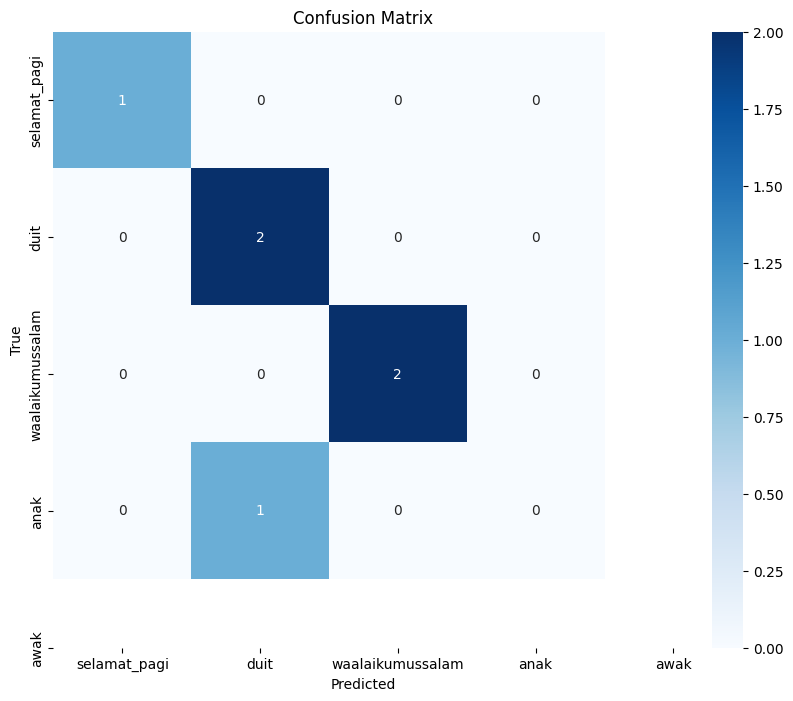

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Classification Report:
              precision    recall  f1-score   support

selamat_pagi       1.00      1.00      1.00         1
        duit       0.67      1.00      0.80         2
        anak       1.00      1.00      1.00         2
        awak       0.00      0.00      0.00         1

    accuracy                           0.83         6
   macro avg       0.67      0.75      0.70         6
weighted avg       0.72      0.83      0.77         6



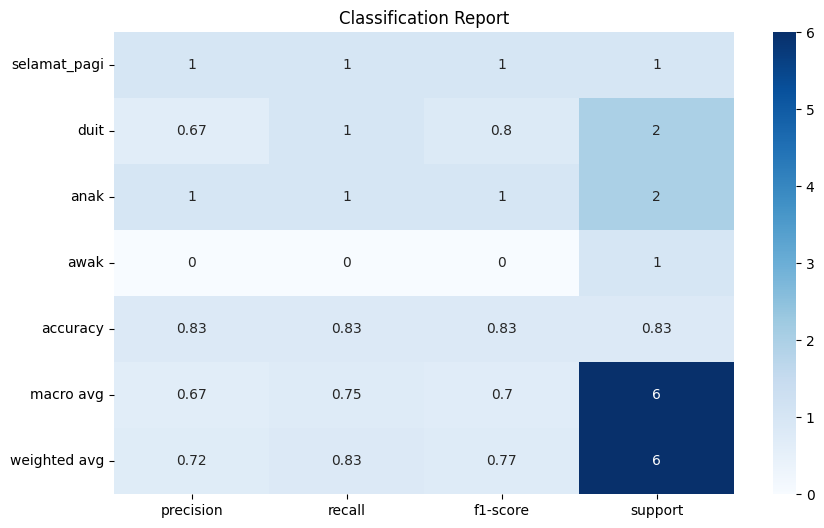

After Hyerparameter tuning where we changed 
    the batch size, hidden layer size and the learning rate 
    the test accuracy increased from 67% to 83%


In [93]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd  # Add this line

# Evaluate the model on the GPU
model.eval()
with torch.no_grad():
    # Convert X_test to a PyTorch tensor and move to GPU
    test_outputs = model(torch.tensor(X_test, dtype=torch.float32).to(device))

    # Convert y_test to a PyTorch tensor of class indices and move to GPU
    y_test_tensor = torch.tensor(y_test.argmax(axis=1), dtype=torch.long).to(device)

    # Compute the test loss
    test_loss = criterion(test_outputs, y_test_tensor)

    # Calculate accuracy
    accuracy = (test_outputs.argmax(dim=1) == y_test_tensor).float().mean()
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy.item():.4f}')

    # Convert predictions and true labels to numpy arrays
    predicted_labels = test_outputs.argmax(dim=1).cpu().numpy()
    true_labels = y_test_tensor.cpu().numpy()

    # Calculate and print the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(conf_matrix)
    print('''After Hyerparameter tuning where we changed
    the batch size, hidden layer size and the learning rate
    the test accuracy increased from 67% to 83%''')
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=gestures, yticklabels=gestures)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Calculate and print the classification report
    # class_report = classification_report(true_labels, predicted_labels, target_names=gestures)
    # print("Classification Report:")
    # print(class_report)
    unique_labels = np.unique(np.concatenate((true_labels, predicted_labels)))

    # Filter target names to match unique labels
    filtered_target_names = [gestures[i] for i in unique_labels]

    class_report = classification_report(
        true_labels,
        predicted_labels,
        target_names=filtered_target_names,
        labels=unique_labels  # Add labels parameter
    )
    print("Classification Report:")
    print(class_report)

    # Plot the classification report
    # plt.figure(figsize=(10, 6))
    # sns.heatmap(pd.DataFrame.from_dict(classification_report(true_labels, predicted_labels, target_names=gestures, output_dict=True)).T, annot=True, cmap='Blues')
    # plt.title('Classification Report')
    # plt.show()

    # Plot the classification report
    plt.figure(figsize=(10, 6))
    # Use filtered_target_names instead of gestures
    sns.heatmap(pd.DataFrame.from_dict(classification_report(true_labels, predicted_labels, target_names=filtered_target_names, output_dict=True)).T, annot=True, cmap='Blues')
    plt.title('Classification Report')
    plt.show()

    print('''After Hyerparameter tuning where we changed
    the batch size, hidden layer size and the learning rate
    the test accuracy increased from 67% to 83%''')


# Model Testing

Testing the model with a single video while Hyperparameters during training were:
- Batch Size = 64
- Learning Rate = 0.0005
- Hidden Layer Size = 128

In [95]:
# Define your custom LSTM model
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, num_classes)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = torch.relu(self.fc1(x[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.output_layer(x)
        return x

# Instantiate the model
input_size = 258
# input_size = 1662
hidden_size = 128
num_classes = len(gestures)
model = CustomLSTM(input_size, hidden_size, num_classes)

# Load the saved model state dictionary
model_filename = 'trained_model.pth'
loaded_model_state_dict = torch.load(model_filename)

# Load the state dictionary into the model
model.load_state_dict(loaded_model_state_dict)
model.eval()  # Set the model to evaluation mode



colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    return output_frame


def get_shape(data):
    if not isinstance(data, list):
        return ()
    return (len(data),) + get_shape(data[0])


# 1. New detection variables
sequence = []
sentence = []
predictions = []

# Replace 'video.mp4' with the path to your video file
cap = cv2.VideoCapture('/content/drive/MyDrive/Occ2_Group7/awak/awak_Occ2_Group7_6.mp4')

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Exit loop if video ends
        if not ret:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if results.left_hand_landmarks or results.right_hand_landmarks:
            if len(sequence) == 30:
                res = model(torch.tensor(np.expand_dims(sequence, axis=0), dtype=torch.float32))
                max_val, max_idx = torch.max(res, dim=1)

                # Print prediction result
                print(max_val)
                print(max_idx)
                print(gestures[max_idx])




<ipython-input-95-ac811ec58c97>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_state_dict = torch.load(model_filename)


tensor([1.8600], grad_fn=<MaxBackward0>)
tensor([2])
waalaikumussalam
tensor([1.4126], grad_fn=<MaxBackward0>)
tensor([2])
waalaikumussalam
tensor([0.8640], grad_fn=<MaxBackward0>)
tensor([2])
waalaikumussalam
tensor([1.2388], grad_fn=<MaxBackward0>)
tensor([1])
duit
tensor([2.7375], grad_fn=<MaxBackward0>)
tensor([1])
duit
tensor([4.4129], grad_fn=<MaxBackward0>)
tensor([1])
duit
tensor([5.5189], grad_fn=<MaxBackward0>)
tensor([1])
duit
tensor([6.0130], grad_fn=<MaxBackward0>)
tensor([1])
duit
tensor([6.1854], grad_fn=<MaxBackward0>)
tensor([1])
duit
tensor([6.2201], grad_fn=<MaxBackward0>)
tensor([1])
duit
tensor([6.2080], grad_fn=<MaxBackward0>)
tensor([1])
duit
tensor([6.1882], grad_fn=<MaxBackward0>)
tensor([1])
duit
tensor([6.1719], grad_fn=<MaxBackward0>)
tensor([1])
duit
tensor([6.1600], grad_fn=<MaxBackward0>)
tensor([1])
duit
tensor([6.1521], grad_fn=<MaxBackward0>)
tensor([1])
duit
tensor([6.1472], grad_fn=<MaxBackward0>)
tensor([1])
duit
tensor([6.1444], grad_fn=<MaxBackwar